In [15]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
from methods.helper import *
from forValentin.model_def import *
from sklearn.metrics import log_loss
from filters import *

In [16]:
# Load data
dataset_path = "C:/Users/mjgoj/PycharmProjects/ThesisFinal/data/final_dataset_split.xlsx"
xls = pd.ExcelFile(dataset_path)

lipidomics = pd.read_excel(xls, "Lipidomics")
metabolomics = pd.read_excel(xls, "Pareto Metabolomics")
proteomics = pd.read_excel(xls, "Pareto Proteomics")
PSG = pd.read_excel(xls, "Pareto PSG")

### Part 2: Nice Pipeline

**Requirements**:
- Custom labeling of the target data
- Possibility to enter different omics blocks 
- Continuous probability as a score instead of binary classification (correct/incorrect)
- Possibility to enter different models (?)

In [17]:
class Block:
    
    def __init__(self, name, data):
        self.name = name
        self.data = data.copy()
        self.clean_data()
        
    def clean_data(self):
        """
        Clean the data by setting the index to RID and removing the target columns
        """
        self.data.set_index('RID', inplace=True, drop=True)
        if 'TwoClass' in self.data.columns:
            self.data = self.data.drop('TwoClass', axis=1)
        if 'ThreeClass' in self.data.columns:
            self.data = self.data.drop('ThreeClass', axis=1)

Testing the `Block` class

In [18]:
def concat_data(blocks, Y):
    """
    Concatenate the data in the blocks and return the training and testing data
    :param blocks: list of Block objects
    :param Y: DataFrame containing the target data
    :return: train_X, test_X, train_y, test_y
    """

    # Get the training and testing RIDs
    train_X, test_X = [], []
    training_RIDs, testing_RIDs = get_train_test_split_RIDs()
    
    # Concatenate the data in the blocks
    for block in blocks:
        train, test = block.data.loc[training_RIDs], block.data.loc[testing_RIDs]
        train_X.append(train)
        test_X.append(test)
    # Convert the data to a DataFrame
    train_X, test_X = pd.concat(train_X, axis=1), pd.concat(test_X, axis=1)
    
    # Split the target variable
    train_y, test_y = Y.loc[training_RIDs, 'TwoClass'], Y.loc[testing_RIDs, 'TwoClass']
    return train_X, test_X, train_y, test_y

In [19]:
# Create blocks
lipidomics_block = Block('lipidomics', lipidomics)
proteomics_block = Block('proteomics', proteomics)
metabolomics_block = Block('metabolomics', metabolomics)
PSG_block = Block('PSG', PSG)

Y_ = proteomics[['RID', 'TwoClass']]
# Change the index to RID
Y_.set_index('RID', inplace=True, drop=True)

### Filtering methods

### Final Prediction Pipeline

In [20]:
def report_results(y_test, binary_pred, prob_pred, plot=True):
    """
    :param plot: whether to plot the metrics
    :param y_test: true labels
    :param binary_pred: the predicted labels
    :param prob_pred: the predicted probabilities
    :return: dictionary of the metrics
    """
    loss = log_loss(y_test, prob_pred)
    mcc = matthews_corrcoef(y_test, binary_pred)
    weighted_f1 = f1_score(y_test, binary_pred, average='weighted')
    fpr, tpr, _ = roc_curve(y_test, prob_pred)
    roc_auc = auc(fpr, tpr)
    
    if plot:
        # Create plots for metrics
        fig, axes = plt.subplots(1, 3, figsize=(9, 4))
            
        # log loss
        loss_color = plt.get_cmap('coolwarm', 100)(100 - int(loss*100))
        axes[0].bar(['Log loss'], [loss], color=loss_color)
        axes[0].set_ylim([0, 1])
        axes[0].set_title('Log loss')
        axes[0].text(0, loss, str(round(loss, 2)), ha='center', va='bottom')
        axes[0].get_xaxis().set_visible(False)
        
        # MCC
        axes[1].axhline(0, color='black', linewidth=0.5)
        mcc_color = plt.get_cmap('coolwarm', 100)(int((mcc+1)*50))
        axes[1].bar(['MCC'], [mcc], color=mcc_color)
        axes[1].set_ylim([-1, 1])
        axes[1].set_title('MCC')
        axes[1].text(0, mcc, str(round(mcc, 2)), ha='center', va='bottom')
        axes[1].get_xaxis().set_visible(False)
        
        # Weighted F1 score
        f1_color = plt.get_cmap('coolwarm', 100)(int(weighted_f1*100))
        axes[2].bar(['Weighted F1 score'], [weighted_f1], color=f1_color)
        axes[2].set_ylim([0, 1])
        axes[2].set_title('Weighted F1 score')
        axes[2].text(0, weighted_f1, str(round(weighted_f1, 2)), ha='center', va='bottom')
        axes[2].get_xaxis().set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Create plots for ROC curve and confusion matrix
        fig, axes = plt.subplots(1, 2, figsize=(9, 4)) 
        
        # ROC curve
        ROC_color = plt.get_cmap('coolwarm', 100)(int(roc_auc*100))
        axes[0].plot(fpr, tpr, color=ROC_color, lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc)
        axes[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        axes[0].set_xlim([0.0, 1.0])
        axes[0].set_ylim([0.0, 1.05])
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title('Receiver operating characteristic')
        axes[0].legend(loc='lower right')
        
        # Confusion matrix
        cm = confusion_matrix(y_test, binary_pred)
        sns.heatmap(cm, annot=True, fmt='g', ax=axes[1], cmap='GnBu')
        axes[1].set_xlabel('Predicted labels')
        axes[1].set_ylabel('True labels')
        axes[1].set_title('Confusion Matrix')
        
        plt.tight_layout()
        plt.show()
    
    return {
        'log_loss': loss,
        'mcc': mcc,
        'weighted f1': weighted_f1,
        'roc_auc': roc_auc
    }

In [21]:
def prediction_pipeline(blocks, Y, model, filter=None):
    """
    :param blocks: list of Block objects
    :param Y: DataFrame containing the target data
    :param model: Model object
    :param filter: Filter object
    """
    
    # Prepare the data
    train_X, test_X, train_y, test_y = concat_data(blocks, Y)
    
    if filter:
        # Filter the data
        model_copy = model.deep_copy()
        features = filter.get_features(train_X, train_y, model_copy)
        train_X, test_X = train_X[features], test_X[features]
        print(f'Selected {len(features)} features')
    
    # Fit the model
    model.fit(train_X, train_y)
    
    # Make the predictions for the new data
    binary_pred, prob_pred = model.predict(test_X)
    
    # Model Evaluation
    report_results(test_y, binary_pred, prob_pred)

### Testing 6 data compositions on the Logistic Regression model

Tuning MIFS: 100%|██████████| 10/10 [03:25<00:00, 20.58s/it]


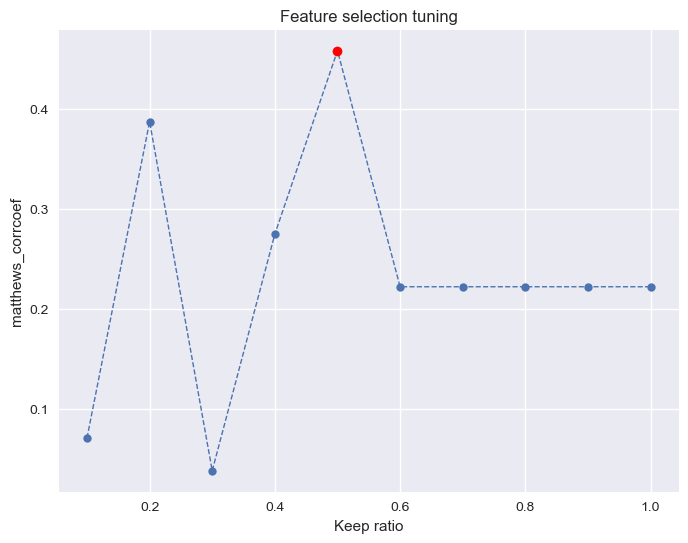

Best keep ratio: 0.5, best score: 0.45834924851410563
Selected keep ratio: 0.5
(580,)
Selected 580 features
Best hyperparameters: {'C': 0.7}


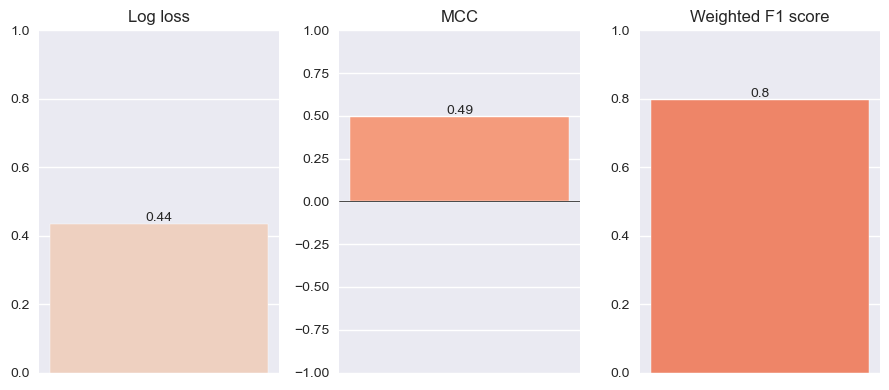

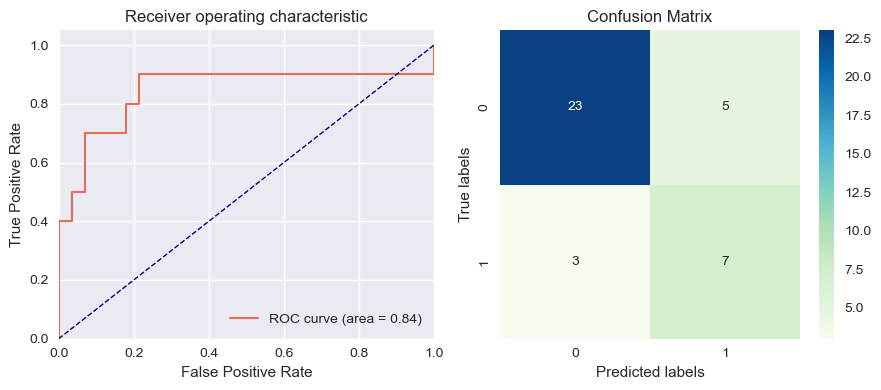

In [22]:
# All existing blocks
prediction_pipeline(
    [lipidomics_block, proteomics_block, metabolomics_block, PSG_block],
    Y_, LogisticRegressionModel(tune=True, scoring='matthews_corrcoef'),
    MIFSFilter(tune_keep_ratio=True))

Tuning MIFS: 100%|██████████| 10/10 [01:30<00:00,  9.09s/it]


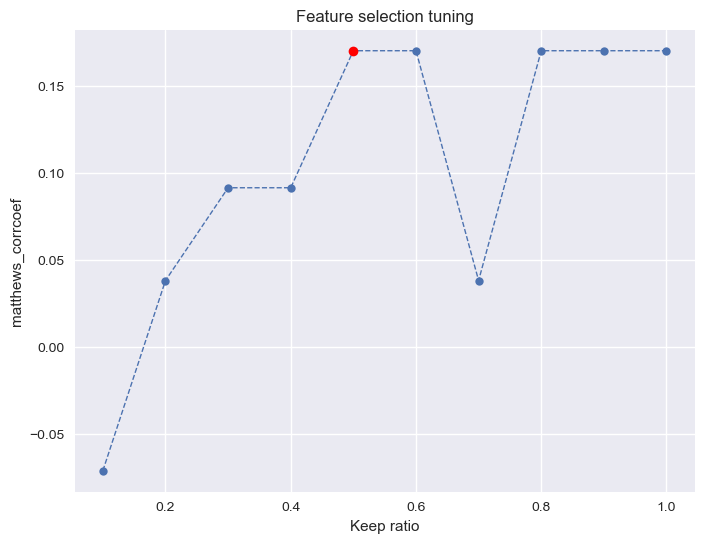

Best keep ratio: 0.5, best score: 0.1704453597146584
Selected keep ratio: 0.5
(420,)
Selected 420 features
Best hyperparameters: {'C': 0.3}


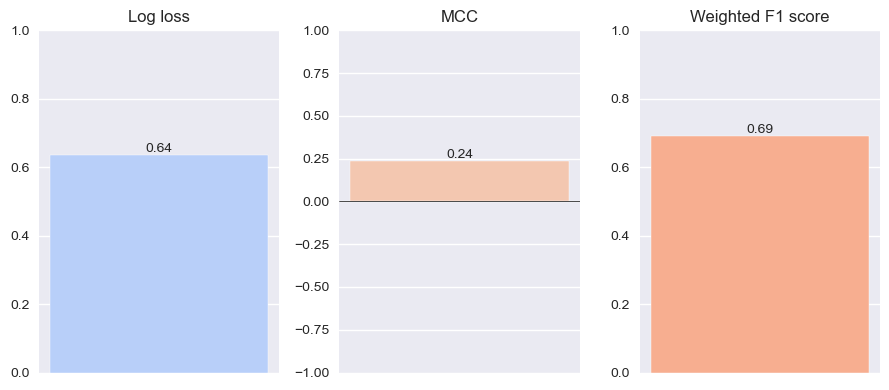

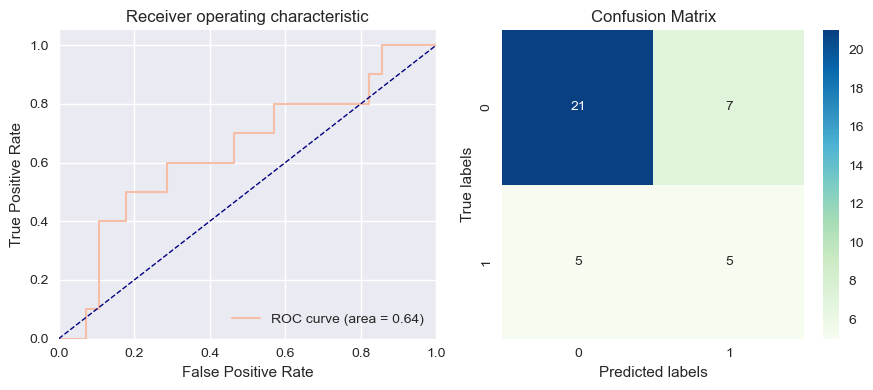

In [23]:
# No CSF proteomics
prediction_pipeline(
    [lipidomics_block, metabolomics_block, PSG_block],
    Y_, LogisticRegressionModel(tune=True, scoring='matthews_corrcoef'),
    MIFSFilter(tune_keep_ratio=True))

Tuning MIFS: 100%|██████████| 10/10 [00:34<00:00,  3.46s/it]


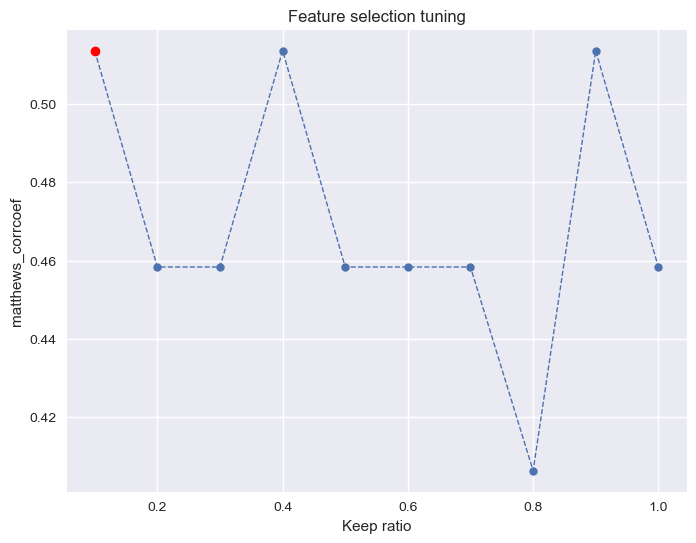

Best keep ratio: 0.1, best score: 0.5136098017959848
Selected keep ratio: 0.1
(32,)
Selected 32 features
Best hyperparameters: {'C': 3}


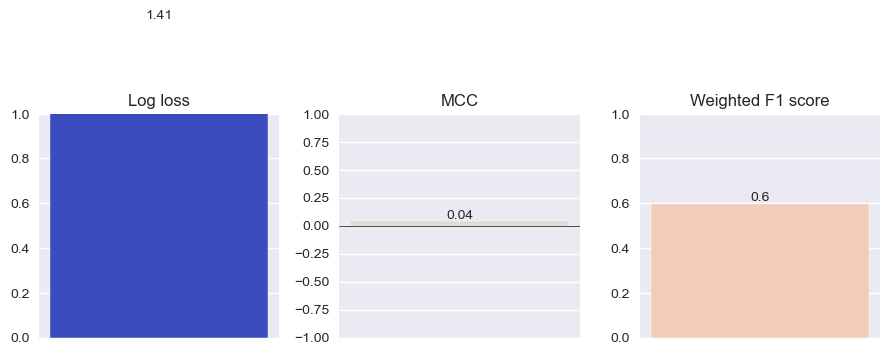

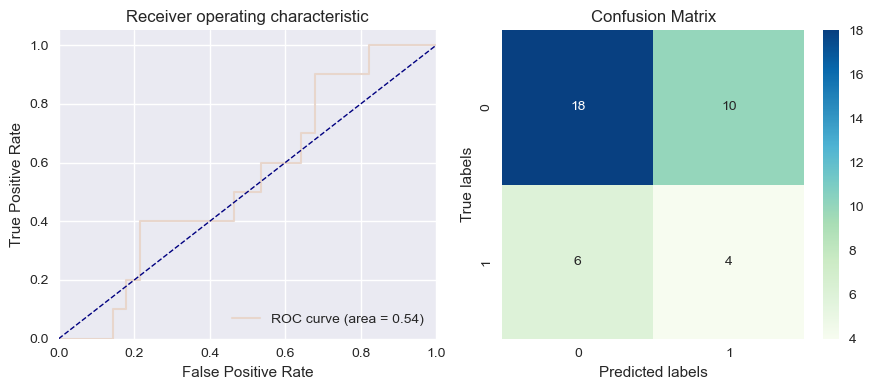

In [24]:
# Single block: proteomics
prediction_pipeline(
    [proteomics_block],
    Y_, LogisticRegressionModel(tune=True, scoring='matthews_corrcoef'),
    MIFSFilter(tune_keep_ratio=True))

Tuning MIFS: 100%|██████████| 10/10 [01:04<00:00,  6.45s/it]


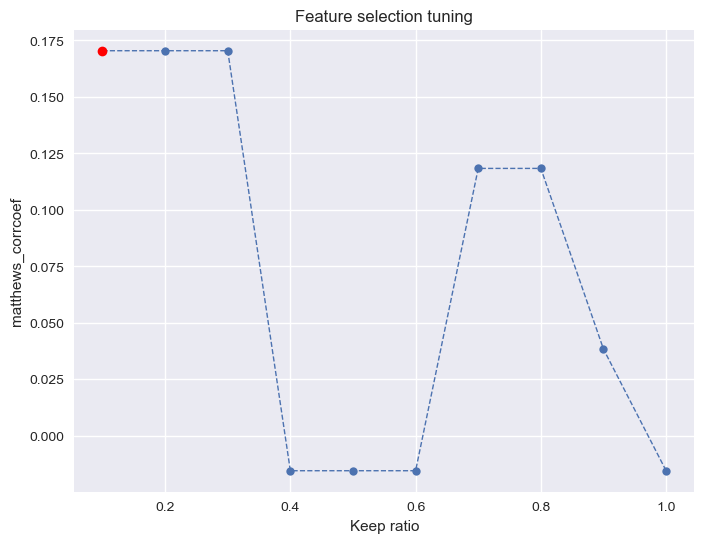

Best keep ratio: 0.1, best score: 0.1704453597146584
Selected keep ratio: 0.1
(57,)
Selected 57 features
Best hyperparameters: {'C': 0.3}


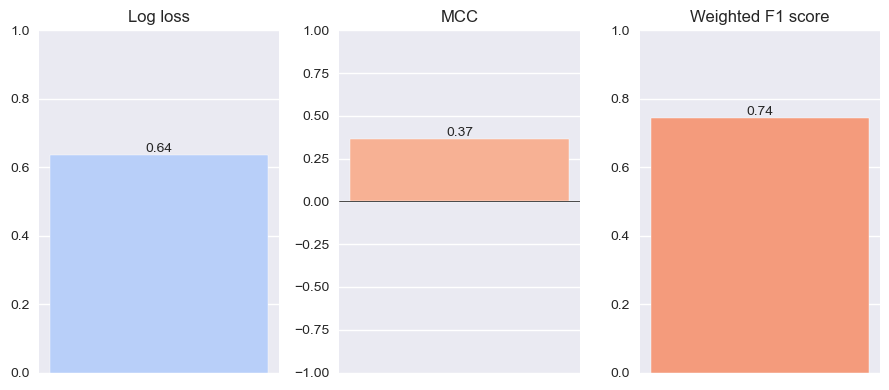

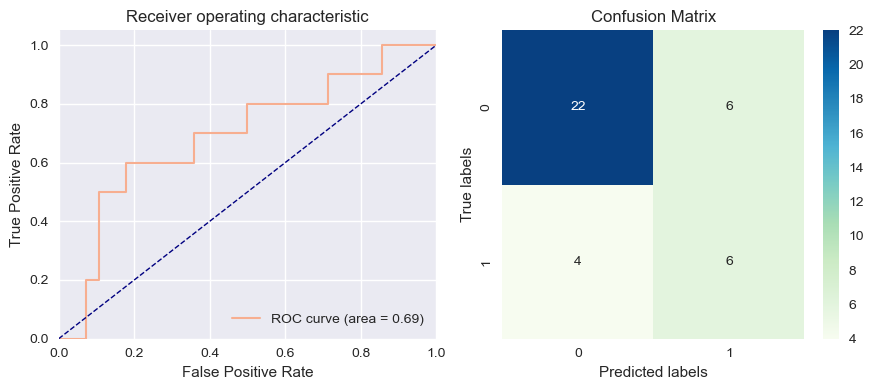

In [25]:
# Single block: lipidomics
prediction_pipeline(
    [lipidomics_block],
    Y_, LogisticRegressionModel(tune=True, scoring='matthews_corrcoef'),
    MIFSFilter(tune_keep_ratio=True))

Tuning MIFS: 100%|██████████| 10/10 [00:23<00:00,  2.32s/it]


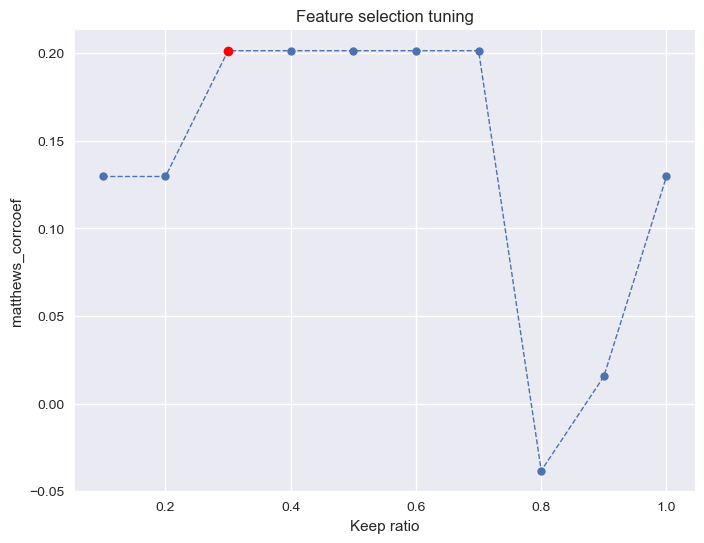

Best keep ratio: 0.3, best score: 0.20143542511732357
Selected keep ratio: 0.3
(63,)
Selected 63 features
Best hyperparameters: {'C': 0.3}


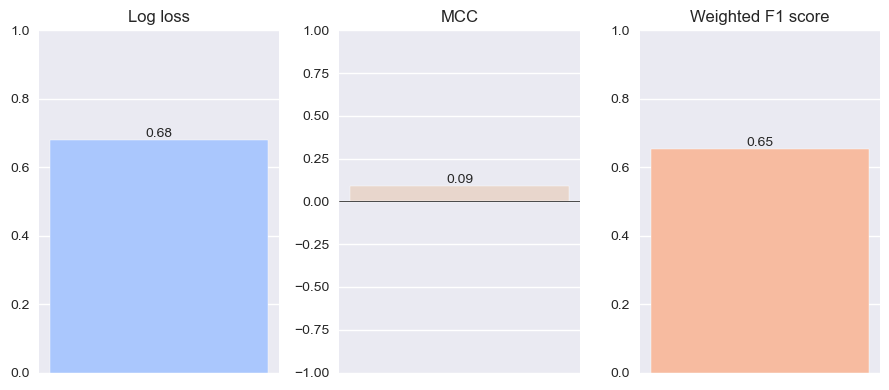

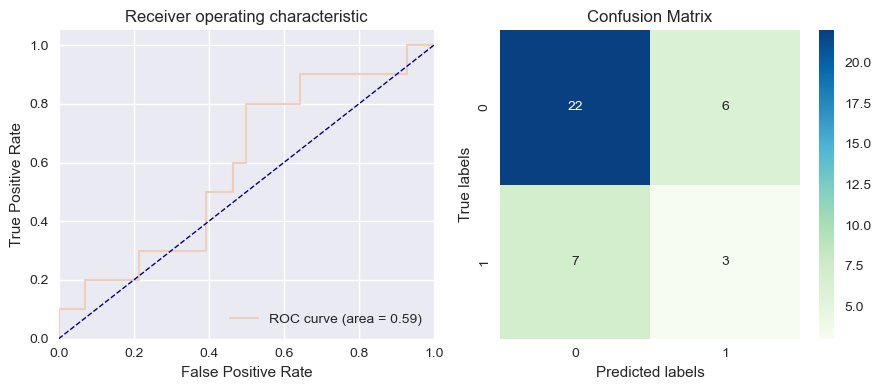

In [26]:
# Single block: metabolomics
prediction_pipeline(
    [metabolomics_block],
    Y_, LogisticRegressionModel(tune=True, scoring='matthews_corrcoef'),
    MIFSFilter(tune_keep_ratio=True))

Tuning MIFS: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


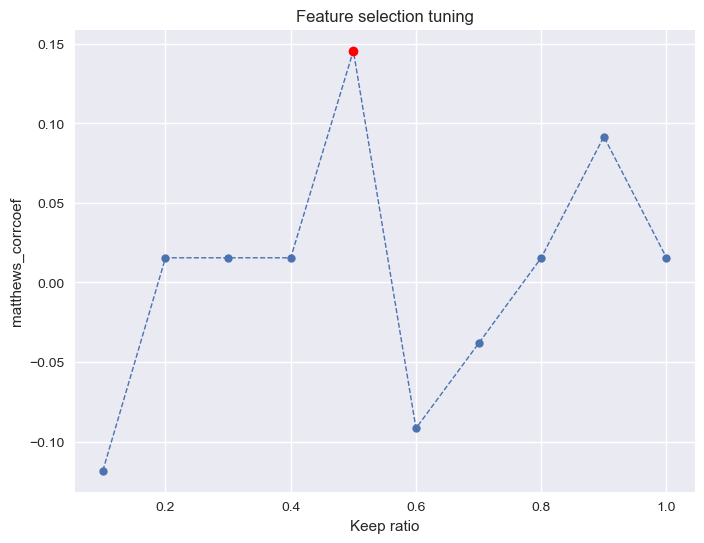

Best keep ratio: 0.5, best score: 0.1456505408078166
Selected keep ratio: 0.5
(24,)
Selected 24 features
Best hyperparameters: {'C': 0.01}


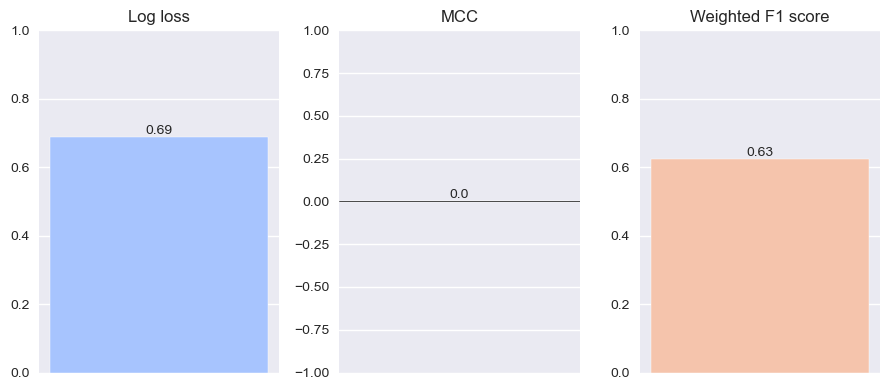

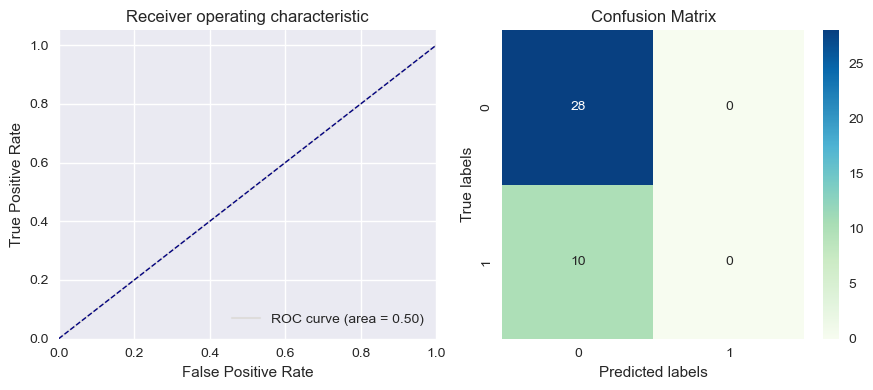

In [27]:
# Single block: PSG
prediction_pipeline(
    [PSG_block],
    Y_, LogisticRegressionModel(tune=True, scoring='matthews_corrcoef'),
    MIFSFilter(tune_keep_ratio=True))